In [1]:
import matplotlib.pyplot as plt
import ase
from ase import io
from ase.visualize import view
from glob import glob
from pathlib import Path
import json
import pandas as pd
import numpy as np
import polars as pl

In [426]:
# import mdanalysis 

In [442]:
import json

def recover_freqs_from_malformed_json(output_path, natoms=42):
    """Unofficial implementation of the 'find out' function
    ('fuck around' function not yet public)"""

    with open(output_path) as f:
        output_str = f.read()

    no_ws = output_str.replace(" ", "")
    no_ws = no_ws.replace("\n", "")
    no_ws_reversed = no_ws[::-1]

    if not "QERF" in no_ws_reversed:
        return None

    darg_idx = no_ws_reversed.index("QERF")
    darg_hit_prefix = no_ws_reversed[0:darg_idx:1][::-1]
    close_bracket_idx = darg_hit_prefix.index("]]")

    txt_array = darg_hit_prefix[2:close_bracket_idx]
    txt_array = txt_array.replace("[", " ")
    txt_array = txt_array.replace("]", " ")

    from io import StringIO

    s = StringIO(txt_array)
    data = np.genfromtxt(s, delimiter=",")
    return data
    


#peaks_dft = recover_gradients_from_malformed_json("/cluster/home/schmidtn/master/wahlprak/orca/pbe0/dih2dscan-1-opt-freq-pbe0.property.json")


Getting files...
r1 file: /cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solnopeptshakeExt/PowerS_res1CO.dat
r2 file: /cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solnopeptshakeExt/PowerS_res2CO.dat
r3a file: /cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solnopeptshakeExt/PowerS_res3CO1.dat
r3b file: /cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solnopeptshakeExt/PowerS_res3CO2.dat
Calculating moving average...
N = 500
Plotting data...
Figure saved as IR-PS-APA-SolutionExt.pdf
Drawing Figure...


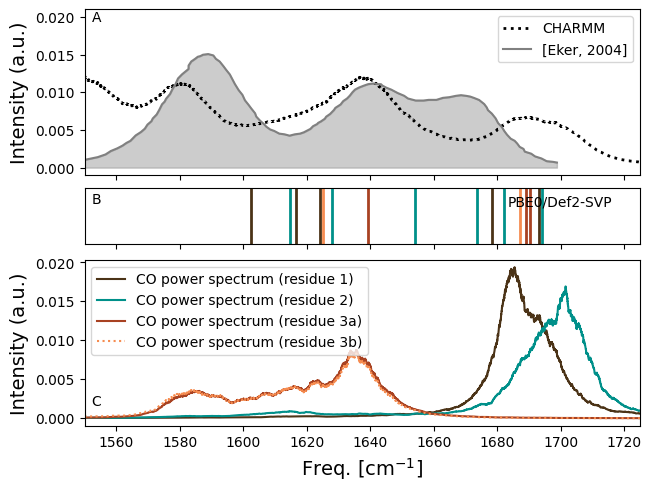

In [485]:


datpath = "/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solnopeptshakeExt/"
#datpath = "/cluster/home/schmidtn/master/wahlprak/charmm/apa-/solution/extended/solution-extended/"
saveoutputas = "IR-PS-APA-SolutionExt"




refspec_path = "/cluster/home/schmidtn/master/wahlprak/charmm/ala/ALALitSpecData.csv"
#refspec_path = "/cluster/home/schmidtn/master/wahlprak/charmm/apa-/APA-LitSpecData.csv"
IRspectrumfilename = "irspectrum.dat"






"""
generates Power and IR spectrum figure from above given path(s)
"""


def plot_PS(datpath, refspec_path, saveoutputas, IRspectrumfilename="irspectrum.dat"):

    color_key = {k:v for k,v in zip(["CO1", "CO2", "CO3a", "CO3b"], [ "#4b3317", "#00908a","#a84222", "#f68c50",])}
    
    """
    gets all files
    """
    
    print("Getting files...")
    
    dat_files = list(Path(datpath).glob("*dat"))
    powspecs = [_ for _ in dat_files if "PowerS" in str(_) ]
    peaks_dft = recover_freqs_from_malformed_json("/cluster/home/schmidtn/master/wahlprak/orca/pbe0/dih2dscan-1-opt-freq-pbe0.property.json")#for peaks of normal modes
    peaks_dft = recover_freqs_from_malformed_json("/cluster/home/schmidtn/master/wahlprak/orca/mp2/restart.property.json")
    r1 = np.genfromtxt(powspecs[0]) #PowerSpectrum Residue1
    print(f"r1 file: {powspecs[0]}")###############################
    r2 = np.genfromtxt(powspecs[1]) #PowerSpectrum Residue2
    print(f"r2 file: {powspecs[1]}")###############################
    r3a = np.genfromtxt(powspecs[2]) #PowerSpectrum Residue3a
    print(f"r3a file: {powspecs[2]}")##############################
    r3b = np.genfromtxt(powspecs[3]) #PowerSpectrum Residue3b
    print(f"r3b file: {powspecs[3]}")##############################
    freq_ir, absorbtion = np.genfromtxt(f"{datpath}{IRspectrumfilename}").T #Data from CHARMM calculated IR spectrum 
    #print(freq_ir)############################################
    exp_ftir = pl.read_csv(refspec_path, has_header=False) #gets reference spectrum data from csv
    exp_ftir = exp_ftir.sort("column_1") #gets reference spectrum data from csv
    exp_freq = [float(_) for _ in exp_ftir["column_1"].to_numpy()] #gets reference spectrum data from csv
    exp_abs = np.array([float(_) for _ in exp_ftir["column_2"].to_numpy()]) #gets reference spectrum data from csv


    
    """
    calculates moving average for power spectra
    """
    
    print("Calculating moving average...")
    
    N = 500
    
    print(f"N = {N}")
    
    freq = np.convolve(r1[:,0], np.ones(N)/N, mode='valid') #gets frequemcies from dat file of residue1 in PowerSpectra
    r1ma = np.convolve(r1[:,1], np.ones(N)/N, mode='valid')
    r2ma = np.convolve(r2[:,1], np.ones(N)/N, mode='valid')
    r3ama = np.convolve(r3a[:,1], np.ones(N)/N, mode='valid')
    r3bma = np.convolve(r3b[:,1], np.ones(N)/N, mode='valid')

    #freq = r1[:,0][499:] #######################???????????????

    print("Plotting data...")
    
    axd = plt.figure(layout="constrained",).subplot_mosaic(
        """
        C
        C
        C
        D
        A
        A
        A
        """, sharex=True
    )
    
    axd["A"].plot(freq, r1ma, label="CO power spectrum (residue 1)", color=color_key["CO1"])
    axd["A"].plot(freq, r2ma, label="CO power spectrum (residue 2)", color=color_key["CO2"])
    axd["A"].plot(freq, r3ama, label="CO power spectrum (residue 3a)", color=color_key["CO3a"])
    axd["A"].plot(freq, r3bma, linestyle="dotted", label="CO power spectrum (residue 3b)", color=color_key["CO3b"])
    
    axd["C"].plot(freq_ir, absorbtion*0.02, linestyle="dotted", label="CHARMM", c="k", linewidth=2.0)
    
    axd["C"].plot(exp_freq, exp_abs*0.1, label="[Eker, 2004]", c="gray")
    
    axd["C"].fill_between(exp_freq, np.zeros_like(exp_freq), exp_abs*0.1, color="gray", alpha=.4)
    
    for i, _ in enumerate(peaks_dft):
        if 81 < (i) < 98:
            c = color_key[peak_labels[i-81]]
            axd["D"].axvline(_ + 90, color=c, linewidth=2)
    
    plt.xlim(1550, 1725)
    
    axd["C"].text(-0.1, 0.5*(0+1), 'Intensity (a.u.)',
            fontsize=14,
            horizontalalignment='right',
            verticalalignment='center',
            rotation='vertical',
            transform=axd["C"].transAxes)
    
    axd["C"].legend(loc="upper right")
    
    axd["A"].text(-0.1, 0.5*(0+1), 'Intensity (a.u.)',
            fontsize=14,
            horizontalalignment='right',
            verticalalignment='center',
            rotation='vertical',
            transform=axd["A"].transAxes)
    
    
    axd["D"].text(0.95, 0.75*(0+1), 'PBE0/Def2-SVP',
            fontsize=10,
            horizontalalignment='right',
            verticalalignment='center',
            transform=axd["D"].transAxes)
    
    
    
    
    axd["A"].text(0.03, 0.15*(0+1), 'C',
            fontsize=10,
            horizontalalignment='right',
            verticalalignment='center',
            transform=axd["A"].transAxes)
    
    axd["D"].text(0.03, 0.8*(0+1), 'B',
            fontsize=10,
            horizontalalignment='right',
            verticalalignment='center',
            transform=axd["D"].transAxes)
    
    axd["C"].text(0.03, 0.95*(0+1), 'A',
            fontsize=10,
            horizontalalignment='right',
            verticalalignment='center',
            transform=axd["C"].transAxes)
    
    axd["D"].set_yticks([])
    
    axd["A"].set_xlabel("Freq. [cm$^{-1}$]", fontsize=14)
    plt.legend()
    #plt.savefig(f"{saveoutputas}.pdf", bbox_inches="tight")   

    print(f"Figure saved as {saveoutputas}.pdf")

    print("Drawing Figure...")
    


plot_PS(datpath, refspec_path, saveoutputas, IRspectrumfilename)
    

In [121]:
dat_files = list(Path("/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/").glob("*dat"))
dat_files

[PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts1.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts2.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/ramtsALASolHiTExt.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/rdfOALASolHiTExtresid1.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/rdfOALASolHiTExtresid2.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts3.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts4.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts5.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/rdfOALASolHiTEx

In [10]:
dipoles = [_ for _ in dat_files if "dip" in str(_) ]
dipoles

[PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts1.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts2.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts3.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts4.dat'),
 PosixPath('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/dipole_ts5.dat')]

In [123]:
powspecs = [_ for _ in dat_files if "PowerS" in str(_) ]
# powspecs_np = [np.genfromtxt(_) for _ in powspecs]
# powspecs

In [135]:
powspecs
4000008//4//2
np.genfromtxt(powspecs[3]).shape

(2000004, 2)

In [136]:
r1, r2, r3a, r3b = np.genfromtxt(powspecs[3]).reshape(4, 500001, 2)

In [166]:
N = 500
freq = np.convolve(r1[:,0], np.ones(N)/N, mode='valid')
r1ma = np.convolve(r1[:,1], np.ones(N)/N, mode='valid')
r2ma = np.convolve(r2[:,1], np.ones(N)/N, mode='valid')
r3ama = np.convolve(r3a[:,1], np.ones(N)/N, mode='valid')
r3bma = np.convolve(r3b[:,1], np.ones(N)/N, mode='valid')

In [167]:
len(freq), len(r1ma)

(499502, 499502)

In [171]:
freq_ir, absorbtion = np.genfromtxt('/cluster/home/schmidtn/master/wahlprak/charmm/ala/solution/extended/solhiTExt/irspectrum.dat').T

In [378]:
freq = r1[:,0][499:]

In [379]:
exp_ftir = pl.read_csv('/cluster/home/schmidtn/master/wahlprak/charmm/ala/data.csv', has_header=False)
exp_ftir = exp_ftir.sort("column_1")
exp_freq = [float(_) for _ in exp_ftir["column_1"].to_numpy()]
exp_abs = np.array([float(_) for _ in exp_ftir["column_2"].to_numpy()])

In [380]:
color_key = {k:v for k,v in zip(["CO1", "CO2", "CO3a", "CO3b"], [ "#4b3317", "#00908a","#a84222", "#f68c50",])}

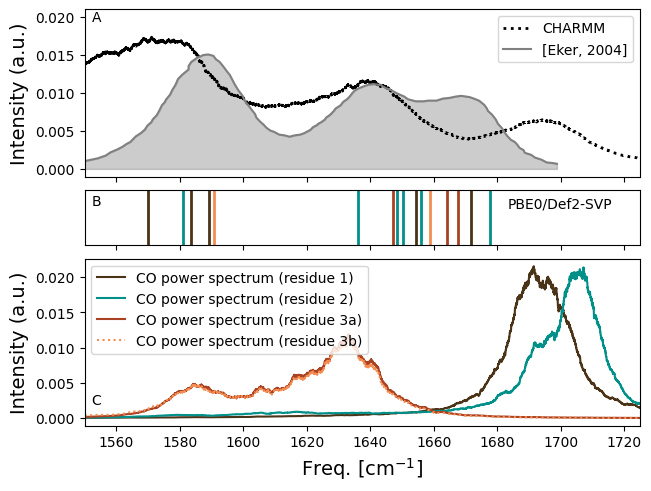

In [437]:
axd = plt.figure(layout="constrained",).subplot_mosaic(
    """
    C
    C
    C
    D
    A
    A
    A
    """, sharex=True
)

axd["A"].plot(freq, r1ma, label="CO power spectrum (residue 1)", color=color_key["CO1"])
axd["A"].plot(freq, r2ma, label="CO power spectrum (residue 2)", color=color_key["CO2"])
axd["A"].plot(freq, r3ama, label="CO power spectrum (residue 3a)", color=color_key["CO3a"])
axd["A"].plot(freq, r3bma, linestyle="dotted", label="CO power spectrum (residue 3b)", color=color_key["CO3b"])

axd["C"].plot(freq_ir, absorbtion*0.02, linestyle="dotted", label="CHARMM", c="k", linewidth=2.0)

axd["C"].plot(exp_freq, exp_abs*0.1, label="[Eker, 2004]", c="gray")

axd["C"].fill_between(exp_freq, np.zeros_like(exp_freq), exp_abs*0.1, color="gray", alpha=.4)

for i, _ in enumerate(peaks_dft):
    if 81 < (i) < 98:
        c = color_key[peak_labels[i-81]]
        axd["D"].axvline(_ + 190, color=c, linewidth=2)

plt.xlim(1550, 1725)

axd["C"].text(-0.1, 0.5*(0+1), 'Intensity (a.u.)',
        fontsize=14,
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axd["C"].transAxes)

axd["C"].legend(loc="upper right")

axd["A"].text(-0.1, 0.5*(0+1), 'Intensity (a.u.)',
        fontsize=14,
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axd["A"].transAxes)


axd["D"].text(0.95, 0.75*(0+1), 'PBE0/Def2-SVP',
        fontsize=10,
        horizontalalignment='right',
        verticalalignment='center',
        transform=axd["D"].transAxes)




axd["A"].text(0.03, 0.15*(0+1), 'C',
        fontsize=10,
        horizontalalignment='right',
        verticalalignment='center',
        transform=axd["A"].transAxes)

axd["D"].text(0.03, 0.8*(0+1), 'B',
        fontsize=10,
        horizontalalignment='right',
        verticalalignment='center',
        transform=axd["D"].transAxes)

axd["C"].text(0.03, 0.95*(0+1), 'A',
        fontsize=10,
        horizontalalignment='right',
        verticalalignment='center',
        transform=axd["C"].transAxes)

axd["D"].set_yticks([])

axd["A"].set_xlabel("Freq. [cm$^{-1}$]", fontsize=14)
plt.legend()
plt.savefig("IR-PS-pbe0.pdf", bbox_inches="tight")

In [416]:
# ?plt.fill_between

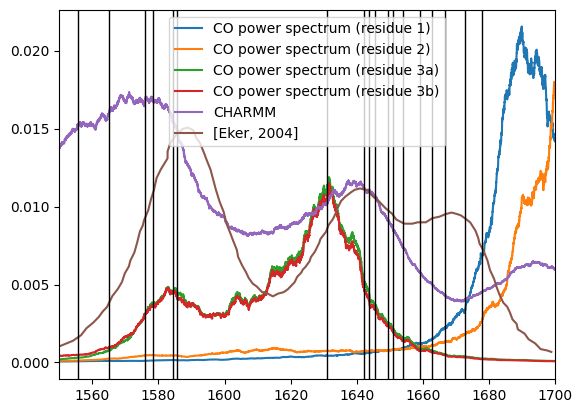

In [234]:

plt.plot(freq, r1ma, label="CO power spectrum (residue 1)")
plt.plot(freq, r2ma, label="CO power spectrum (residue 2)")
plt.plot(freq, r3ama, label="CO power spectrum (residue 3a)")
plt.plot(freq, r3bma, label="CO power spectrum (residue 3b)")
plt.plot(freq_ir, absorbtion*0.02, label="CHARMM")
plt.plot(exp_freq, exp_abs*0.1, label="[Eker, 2004]")

for _ in peaks_dft:
    plt.axvline(_ + 185, color="k", linewidth=1)


plt.xlim(1550, 1700)

plt.legend()

In [270]:
bondNMs = np.genfromtxt("/cluster/home/schmidtn/master/wahlprak/orca/pbe0/bond-normal-modes.dat")
bondNMs

array([[  0.      ,   1.324567,   1.327208,   1.327093,   1.201309],
       [  1.      ,   1.323666,   1.323917,   1.322895,   1.203094],
       [  2.      ,   1.322863,   1.320983,   1.319156,   1.204693],
       ...,
       [357.      ,   1.287579,   1.279216,   1.260547,   1.218417],
       [358.      ,   1.304941,   1.301724,   1.291775,   1.210083],
       [359.      ,   1.324567,   1.327208,   1.327093,   1.201309]],
      shape=(360, 5))

<Axes: xlabel='frame'>

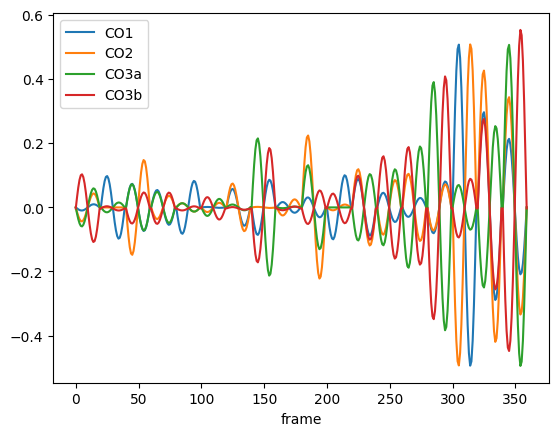

In [304]:
df_ass = pd.DataFrame(bondNMs, columns=["frame", "CO1", "CO2", "CO3a", "CO3b"]) 
df_ass["peakNumber"] = df_ass["frame"].apply(lambda x: int( (x//20) + 81))

for k in ["CO1", "CO2", "CO3a", "CO3b"]:
    df_ass[k] = (df_ass[k] - df_ass[k].min()) / (df_ass[k].max() - df_ass[k].min())
    df_ass[k] = df_ass[k] - df_ass[k].mean()
df_ass.plot("frame", ["CO1", "CO2", "CO3a", "CO3b"])

In [325]:
peak_labels = []

for i, _ in enumerate(df_ass[["CO1", "CO2", "CO3a", "CO3b", "peakNumber"]].groupby("peakNumber").std().to_numpy()):
    print(i+81, _)
    l = ["CO1", "CO2", "CO3a", "CO3b"][int(np.where(_ == max(_))[0])]
    peak_labels.append(l)

81 [0.00684932 0.03089671 0.04204086 0.07480119]
82 [0.06917284 0.00016524 0.01083381 0.00466604]
83 [0.05202263 0.10468315 0.05117058 0.03427775]
84 [0.03841104 0.02567946 0.0342406  0.03451019]
85 [0.05840396 0.00912002 0.00927283 0.00451083]
86 [0.00096798 0.01015941 0.01882669 0.02473748]
87 [0.04066614 0.0526071  0.00639306 0.00287073]
88 [0.06086718 0.00120531 0.15161711 0.12631573]
89 [0.0117857  0.0177704  0.00172922 0.00405509]
90 [0.0219462  0.15803916 0.09274634 0.03706156]
91 [7.08313158e-02 6.33990778e-03 4.76788835e-05 3.27133798e-02]
92 [0.06246724 0.0842533  0.07334665 0.07075778]
93 [0.03225685 0.06034338 0.08394891 0.11304954]
94 [0.02090123 0.07419578 0.13395044 0.12988914]
95 [0.05718932 0.05093705 0.2742579  0.26858973]
96 [0.35490717 0.35489473 0.04936403 0.06482936]
97 [0.2075401  0.29978658 0.17830165 0.18839581]
98 [0.14974632 0.24022203 0.35486455 0.35558581]


/tmp/ipykernel_6614/412612119.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l = ["CO1", "CO2", "CO3a", "CO3b"][int(np.where(_ == max(_))[0])]


In [328]:
peak_labels

['CO3b',
 'CO1',
 'CO2',
 'CO1',
 'CO1',
 'CO3b',
 'CO2',
 'CO3a',
 'CO2',
 'CO2',
 'CO1',
 'CO2',
 'CO3b',
 'CO3a',
 'CO3a',
 'CO1',
 'CO2',
 'CO3b']

In [302]:
styler = df_ass.groupby("peakNumber").std().style
(styler.text_gradient(cmap="Reds"))

,frame,CO1,CO2,CO3a,CO3b
peakNumber,,,,,
81,5.916080,0.006849,0.030897,0.042041,0.074801
82,5.916080,0.069173,0.000165,0.010834,0.004666
83,5.916080,0.052023,0.104683,0.051171,0.034278
84,5.916080,0.038411,0.025679,0.034241,0.034510
85,5.916080,0.058404,0.009120,0.009273,0.004511
86,5.916080,0.000968,0.010159,0.018827,0.024737
87,5.916080,0.040666,0.052607,0.006393,0.002871
88,5.916080,0.060867,0.001205,0.151617,0.126316
89,5.916080,0.011786,0.017770,0.001729,0.004055


In [297]:
df_ass.groupby("peakNumber").std()

,frame,CO1,CO2,CO3a,CO3b
peakNumber,,,,,
81,5.91608,0.001962,0.007167,0.009143,0.003880
82,5.91608,0.019815,0.000038,0.002356,0.000242
83,5.91608,0.014902,0.024284,0.011129,0.001778
84,5.91608,0.011003,0.005957,0.007447,0.001790
85,5.91608,0.016730,0.002116,0.002017,0.000234
86,5.91608,0.000277,0.002357,0.004095,0.001283
87,5.91608,0.011649,0.012204,0.001390,0.000149
88,5.91608,0.017436,0.000280,0.032975,0.006551
89,5.91608,0.003376,0.004122,0.000376,0.000210


In [239]:
for i, invcm in enumerate(peaks_dft):
    if 1550 < (invcm + 185) < 1700:
        print(i, invcm)
    

81 1370.814912429
82 1380.114290052
83 1390.882165862
84 1393.412936474
85 1399.327966485
86 1400.765593388
87 1446.119762417
88 1457.073481832
89 1458.590249375
90 1460.447365728
91 1464.284027807
92 1465.963539598
93 1468.821704167
94 1474.152638135
95 1477.770749516
96 1481.77765012
97 1487.682484986
98 1492.957938518


In [ ]:
fig = plt.figure(layout="constrained")
ax_dict = fig.subplot_mosaic(
    [
        ["bar", "plot"],
        ["hist", "image"],
    ],
)
ax_dict["bar"].bar(["a", "b", "c"], [5, 7, 9])
ax_dict["plot"].plot([1, 2, 3])
ax_dict["hist"].hist(hist_data)
ax_dict["image"].imshow([[1, 2], [2, 1]])
identify_axes(ax_dict)

In [11]:
dipoles_np = [np.genfromtxt(_) for _ in dipoles]

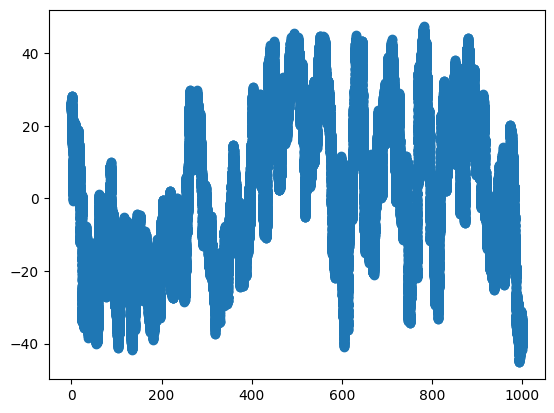

In [14]:
_ = dipoles_np[0]

plt.scatter(_[:,0], _[:,1])

In [104]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

magnitude = np.linalg.norm(_[:,1:], axis=1)
angles = angle_between(_[:,1:], np.array([0,1,0]))

xs = np.cos(angles)
ys = np.sin(angles)
ts = _[:,0]



In [105]:
_[0,:], angles

(array([ 5.0000000e-03,  2.5736972e+01, -5.4491840e+00, -1.1869397e+01]),
 array([1.57114429, 1.57116778, 1.57117362, ..., 1.56909548, 1.56910767,
        1.56913719], shape=(200000,)))

In [106]:
np.rad2deg(angles)
ts[::skip], xs[::skip]*10, ys[::skip]*10

(array([5.00000e-03, 5.50000e-02, 1.05000e-01, ..., 9.99855e+02,
        9.99905e+02, 9.99955e+02], shape=(20000,)),
 array([-0.0034796 , -0.00310024, -0.00259228, ...,  0.01573479,
         0.01514571,  0.0158867 ], shape=(20000,)),
 array([9.99999939, 9.99999952, 9.99999966, ..., 9.99998762, 9.99998853,
        9.99998738], shape=(20000,)))

Text(0.5, 0, 'Time (ps)')

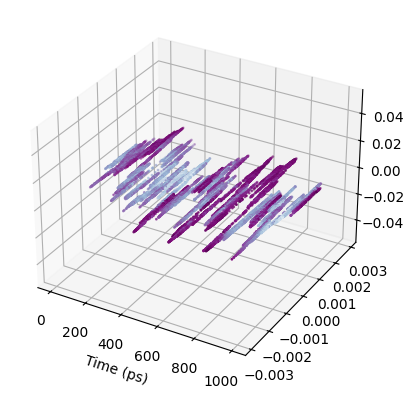

In [110]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
skip = 10
plt.scatter(ts[::skip], xs[::skip], ys[::skip], c=magnitude[::skip], cmap="BuPu")
# plt.colorbar(c, orientation="horizontal")
ax = plt.gca()
plt.xlabel("Time (ps)")


Text(0.5, 0, 'z')

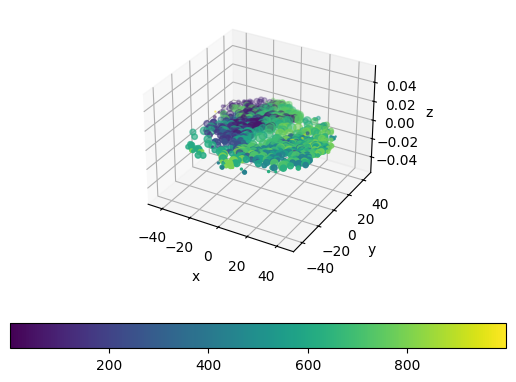

In [61]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
skip = 100
c = plt.scatter(_[::skip, 1], _[::skip, 2], _[::skip, 3], c=ts[::skip])
plt.colorbar(c, orientation="horizontal")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_zlabel("z")

In [44]:
pd.DataFrame({"t": ts, "x": xs, "y": ys, "angle": angles, "mag": magnitude})

,t,x,y,angle,mag
0,0.005,-12.471098,26.027670,89.982218,28.861184
1,0.010,-12.484564,25.979132,89.983367,28.823249
2,0.015,-12.479715,25.984516,89.983134,28.826002
3,0.020,-12.569883,26.242131,89.982095,29.097275
4,0.025,-12.587312,26.254905,89.982445,29.116326
...,...,...,...,...,...
199995,999.980,-22.427190,39.588691,90.050817,45.499926
199996,999.985,-23.109582,40.709535,90.051699,46.811527
199997,999.990,-23.379949,41.203288,90.051517,47.374391
199998,999.995,-23.133362,40.809274,90.051090,46.910013


In [31]:
magnitude

array([28.86118361, 28.82324854, 28.82600206, ..., 47.37439132,
       46.91001274, 46.55066263], shape=(200000,))

In [35]:
np.linalg.norm(_[:,1:], axis=1)

array([28.86118361, 28.82324854, 28.82600206, ..., 47.37439132,
       46.91001274, 46.55066263], shape=(200000,))

In [38]:
np.cos(angles)

array([ 0.00031036,  0.00029031,  0.00029436, ..., -0.00089914,
       -0.00089169, -0.00090847], shape=(200000,))

In [51]:
magnitude * np.cos(angles)

array([ 0.00895737,  0.00836758,  0.00848536, ..., -0.04259598,
       -0.04182911, -0.04228982], shape=(200000,))